In [1]:
%load_ext autoreload
%autoreload 2

## 0. Preproceso de los datos

Se cargan los datos en formato `.nc` y se guardan como `.csv` para facilitar su manejo.

**Nota:** Este paso no es necesario, ya que los datos también están en formato `.csv`

In [2]:
import xarray as xr
import pandas as pd

ds = xr.open_dataset("data/raw/currents.nc")
uo = ds["uo"].isel(time=0).values
df_uo = pd.DataFrame(uo, columns=ds.longitude.values, index=ds.latitude.values).iloc[
    ::-1
]
df_uo.to_csv("data/uo.csv")

vo = ds["vo"].isel(time=0).values
df_vo = pd.DataFrame(vo, columns=ds.longitude.values, index=ds.latitude.values).iloc[
    ::-1
]
df_vo.to_csv("data/vo.csv")

ds

<xarray.Dataset> Size: 71MB
Dimensions:    (time: 1, latitude: 2041, longitude: 4320)
Coordinates:
  * longitude  (longitude) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9
  * latitude   (latitude) float32 8kB -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * time       (time) datetime64[ns] 8B 2023-01-01
Data variables:
    vo         (time, latitude, longitude) float32 35MB ...
    uo         (time, latitude, longitude) float32 35MB ...

## 1. Objeto Océano

Para gestionar los datos de corrientes marinas, se ha diseñado un objeto `Oceano` que permite cargar los datos y realizar cálculos sobre ellos.

Este objeto tiene los siguientes métodos:
- `__init__(df_vo, df_uo)`: Constructor de la clase. Puede recibir 2 dataframes o las rutas a sus correspondientes `.csv`.
- `crop_data(bounding_box)`: Recorta los datos a una región rectangular. Es útil para reducir el tamaño de los datos y acelerar los cálculos.
- `get_currents(lat, lon)`: Devuelve las componentes de la corriente en un punto especifico. Si el punto está en tierra se obtiene NaN.
- `plot_currents(...)`: Muestra un mapa con las velocidades de las corrientes. Para conocer todos los parámetros, consultar la documentación de la función.

In [3]:
from src.data import Ocean

ocean_data = Ocean("data/vo.csv", "data/uo.csv")

print("Corrientes en el océano:", ocean_data.get_currents(lat=0, lon=0))
print("Corrientes en tierra:", ocean_data.get_currents(lat=0, lon=25))

Corrientes en el océano: (0.13841335, -0.16285518)
Corrientes en tierra: (nan, nan)


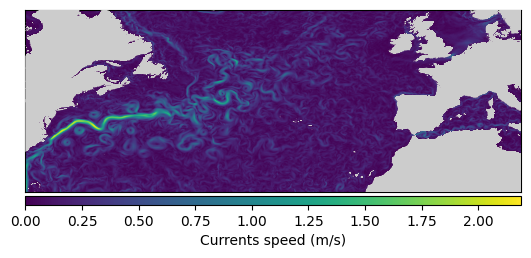

In [4]:
ocean_data.crop_data([25, -80, 60, 15])
basemap, fig, ax = ocean_data.plot_currents()

## 2. Cálculo de tiempo

Para calcular el tiempo que se tarda en ir de un punto a otro del océano, se ha diseñado la función `compute_time`.

Para hacer el cálculo, además de las coordenadas de origen y destino, se necesita la velocidad de la embarcación y los datos de corrientes.

In [6]:
from src.simulation import compute_time

time = compute_time(
    lat_start=36.5,
    lon_start=-73,
    lat_end=36.5,
    lon_end=-74.5,
    vel_ship=3,
    ocean_data=ocean_data,
)

time

105655.71547029498